https://python.langchain.com/docs/modules/agents/how_to/custom_agent/

In [1]:
from getpass import getpass

In [2]:
OPENAI_API_KEY = getpass(prompt='Enter your OpenAI Token:')

Enter your OpenAI Token: ········


In [3]:
from ase.atoms import Atoms
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.constraints import UnitCellFilter
from ase.eos import calculate_eos, plot
from ase.data import reference_states, atomic_numbers
from ase.optimize import LBFGS
from ase.units import kJ

In [4]:
from mace.calculators import mace_mp

In [5]:
from langchain.agents import tool

In [6]:
import matplotlib.pyplot as plt

In [7]:
from langchain_core.pydantic_v1 import BaseModel

In [8]:
import numpy as np

In [9]:
from typing import List

In [10]:
class AtomsDict(BaseModel):
    numbers: List[int]
    positions: List[List[float]]
    cell: List[List[float]]
    pbc: List[bool]

In [11]:
AtomsDict.schema()

{'title': 'AtomsDict',
 'type': 'object',
 'properties': {'numbers': {'title': 'Numbers',
   'type': 'array',
   'items': {'type': 'integer'}},
  'positions': {'title': 'Positions',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}},
  'cell': {'title': 'Cell',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}},
  'pbc': {'title': 'Pbc', 'type': 'array', 'items': {'type': 'boolean'}}},
 'required': ['numbers', 'positions', 'cell', 'pbc']}

In [12]:
def get_calculator(calculator_str: str = "emt"):
    if calculator_str == "emt":
        return EMT()
    elif calculator_str == "mace":
        return mace_mp(
            model="medium",
            dispersion=False,
            default_dtype="float32",
            device='cpu'
        )

In [13]:
@tool 
def get_equilibirum_lattice(chemical_symbol: str, calculator_str: str) -> AtomsDict:
    """Returns equilibrium atoms dictionary for a given chemical symbol and a selected model specified by the calculator string"""
    atoms = bulk(name=chemical_symbol)
    atoms.calc = get_calculator(calculator_str=calculator_str)
    ase_optimizer_obj = LBFGS(UnitCellFilter(atoms))
    ase_optimizer_obj.run(fmax=0.000001)
    return AtomsDict(**{k: v.tolist() for k, v in atoms.todict().items()})

In [14]:
@tool
def plot_equation_of_state(atom_dict: AtomsDict, calculator_str: str) -> str:
    """Returns plot of equation of state of chemical symbol for a given atoms dictionary and a selected model specified by the calculator string"""
    atoms = Atoms(**atom_dict.dict())
    atoms.calc = get_calculator(calculator_str=calculator_str)
    eos = calculate_eos(atoms)
    plotdata = eos.getplotdata()
    return plot(*plotdata)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 16:56:17       -0.001502*       0.1618
LBFGS:    1 16:56:17       -0.002533*       0.1355
LBFGS:    2 16:56:17       -0.004879*       0.0055
LBFGS:    3 16:56:17       -0.004883*       0.0002
LBFGS:    4 16:56:17       -0.004883*       0.0000


<Axes: title={'center': 'sj: E: -0.005 eV, V: 15.932 Å$^3$, B: 39.519 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

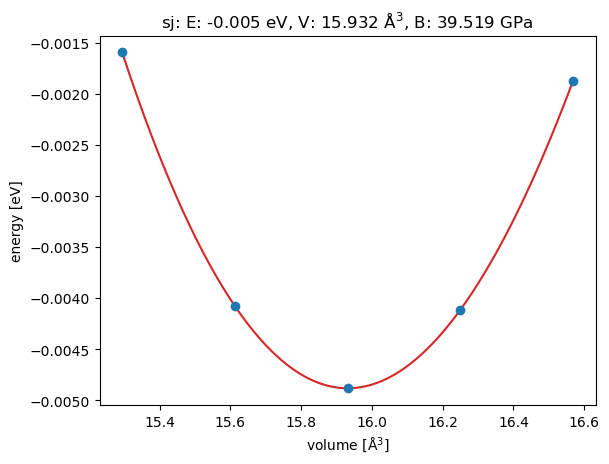

In [15]:
el = "Al"
structure_dict = get_equilibirum_lattice.invoke({"chemical_symbol": el, "calculator_str": "emt"})
plot_equation_of_state.invoke({"atom_dict": structure_dict, "calculator_str": "emt"})

In [16]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key=OPENAI_API_KEY)

In [17]:
tools = [get_equilibirum_lattice, plot_equation_of_state]

In [18]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            # "You are very powerful assistant, but don't know current events.",
            # "You are very powerful assistant, but don't know current events. For each query vailidate that it contains a chemical element and otherwise cancel.",
            "You are very powerful assistant, but don't know current events. To calculate with emt use the calculator string emt and to calculate with mace use the calculator string mace. For each query vailidate that it contains a chemical element and a calculator string and otherwise use Alumninum as the default chemical element and emt as the default calculator string.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [19]:
llm_with_tools = llm.bind_tools(tools)

In [20]:
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [21]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)



> Entering new AgentExecutor chain...

Invoking: `get_equilibirum_lattice` with `{'chemical_symbol': 'Au', 'calculator_str': 'emt'}`


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 16:56:19        0.002606*       0.3089
LBFGS:    1 16:56:19        0.000032*       0.0778
LBFGS:    2 16:56:19       -0.000135*       0.0031
LBFGS:    3 16:56:19       -0.000135*       0.0000
LBFGS:    4 16:56:19       -0.000135*       0.0000
numbers=[79] positions=[[0.0, 0.0, 0.0]] cell=[[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]] pbc=[True, True, True]
Invoking: `plot_equation_of_state` with `{'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203],

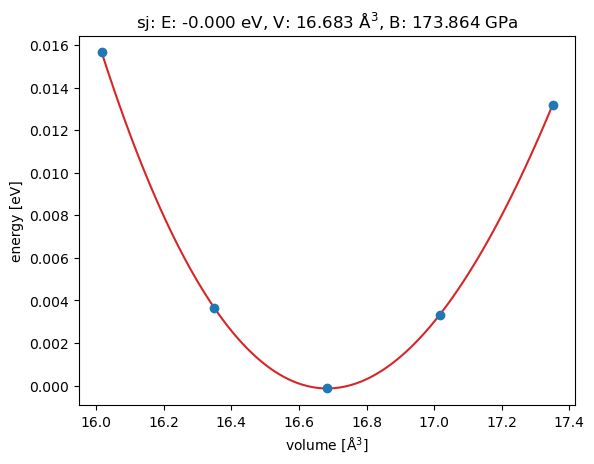

In [22]:
lst = list(agent_executor.stream({"input": "Plot the equation of state of gold"}))  # Yeah this worked !!

In [23]:
lst[0]

{'actions': [ToolAgentAction(tool='get_equilibirum_lattice', tool_input={'chemical_symbol': 'Au', 'calculator_str': 'emt'}, log="\nInvoking: `get_equilibirum_lattice` with `{'chemical_symbol': 'Au', 'calculator_str': 'emt'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ZVCHIZQbJ7svhHrEIJQy6xcc', 'function': {'arguments': '{"chemical_symbol":"Au","calculator_str":"emt"}', 'name': 'get_equilibirum_lattice'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-a1e7afb6-18ca-4e9b-9167-697c3da19553', tool_calls=[{'name': 'get_equilibirum_lattice', 'args': {'chemical_symbol': 'Au', 'calculator_str': 'emt'}, 'id': 'call_ZVCHIZQbJ7svhHrEIJQy6xcc'}], tool_call_chunks=[{'name': 'get_equilibirum_lattice', 'args': '{"chemical_symbol":"Au","calculator_str":"emt"}', 'id': 'call_ZVCHIZQbJ7svhHrEIJQy6xcc', 'index': 0}])], tool_call_id='call_ZVCHIZQbJ7svhHrEIJQy6xcc')],
 'messages': [AIMessageChunk(content='', a

In [24]:
lst[1]

{'steps': [AgentStep(action=ToolAgentAction(tool='get_equilibirum_lattice', tool_input={'chemical_symbol': 'Au', 'calculator_str': 'emt'}, log="\nInvoking: `get_equilibirum_lattice` with `{'chemical_symbol': 'Au', 'calculator_str': 'emt'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ZVCHIZQbJ7svhHrEIJQy6xcc', 'function': {'arguments': '{"chemical_symbol":"Au","calculator_str":"emt"}', 'name': 'get_equilibirum_lattice'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-a1e7afb6-18ca-4e9b-9167-697c3da19553', tool_calls=[{'name': 'get_equilibirum_lattice', 'args': {'chemical_symbol': 'Au', 'calculator_str': 'emt'}, 'id': 'call_ZVCHIZQbJ7svhHrEIJQy6xcc'}], tool_call_chunks=[{'name': 'get_equilibirum_lattice', 'args': '{"chemical_symbol":"Au","calculator_str":"emt"}', 'id': 'call_ZVCHIZQbJ7svhHrEIJQy6xcc', 'index': 0}])], tool_call_id='call_ZVCHIZQbJ7svhHrEIJQy6xcc'), observation=AtomsDict(number

In [25]:
lst[2]

{'actions': [ToolAgentAction(tool='plot_equation_of_state', tool_input={'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]], 'pbc': [True, True, True]}, 'calculator_str': 'emt'}, log="\nInvoking: `plot_equation_of_state` with `{'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]], 'pbc': [True, True, True]}, 'calculator_str': 'emt'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_79g0SAZKUoQd88fUooFeSTmk', 'function': {'arguments': '{"atom_dict":{"numbers":[79],"positions":[[0.0,0.0,0.0]],"cell":[[4.7132

In [26]:
lst[3]

{'steps': [AgentStep(action=ToolAgentAction(tool='plot_equation_of_state', tool_input={'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]], 'pbc': [True, True, True]}, 'calculator_str': 'emt'}, log="\nInvoking: `plot_equation_of_state` with `{'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]], 'pbc': [True, True, True]}, 'calculator_str': 'emt'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_79g0SAZKUoQd88fUooFeSTmk', 'function': {'arguments': '{"atom_dict":{"numbers":[79],"positions":[[0.0,0.0,0.0]],

In [27]:
lst[4]

{'output': 'Here is the plot of the equation of state of gold.',
 'messages': [AIMessage(content='Here is the plot of the equation of state of gold.')]}



> Entering new AgentExecutor chain...

Invoking: `get_equilibirum_lattice` with `{'chemical_symbol': 'Au', 'calculator_str': 'mace'}`


Using Materials Project MACE for MACECalculator with /Users/janssen/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/janssen/mambaforge_llm/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Users/janssen/mambaforge_llm/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Users/janssen/mambaforge_llm/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Users/janssen/mambaforge_llm/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 16:56:24       -3.205707*       1.2044
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only 

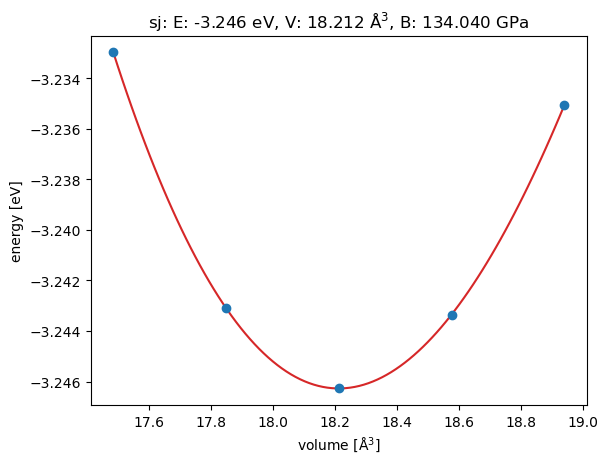

In [28]:
lst = list(agent_executor.stream({"input": "Plot the equation of state of gold calculated with the mace model"}))  # Yeah this worked !!

In [29]:
lst = list(agent_executor.stream({"input": "Plot the equation of state"}))  # This worked before but does not work now !!



> Entering new AgentExecutor chain...
I need to know the chemical symbol and the calculator string to plot the equation of state. Please provide me with the chemical symbol and the calculator string you would like to use.

> Finished chain.


# Lessons learned: 
* Handling types between python functions is still ugly, it is not possible to transfer ASE atoms objects. Rather we use pydantic classes, still even for those tuples are not allowed. 